# **Application to a gridded product:** Example with ISAS15 data
# pyXpcm standard figures and diagnostic tools

In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import intake
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))
import pyxpcm

from pyxpcm.models import pcm
from pyxpcm import datasets as pcmdata
from pyxpcm import plot as pcmplot
# from pyxpcm import stats as pcmstats

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib as mpl

# Load data

In [2]:
ds = pcmdata.load_isas15()
print('This dataset holds: %.3f MB' % (ds.nbytes / 1e6))
print(ds)

This dataset holds: 11.808 MB
<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 24.458 ... 3.4309998
    TEMP_ERR     (depth, latitude, longitude) float32 0.33 0.328 ... 0.049000002
    TEMP_PCTVAR  (depth, latitude, longitude) float32 31.0 31.0 ... 99.0 99.0
    PSAL         (depth, latitude, longitude) float32 36.632 36.658 ... 34.917
    PSAL_ERR     (depth, latitude, longitude) float32 0.051000003 ... 0.006
    PSAL_PCTVAR  (depth, latitude, longitude) float32 32.0 32.0 ... 99.0 99.0
    SST          (latitude, longitude) float32 24.458 24.448 ... 13.216999


# Define/fit/predict a standard pyXpcm

In [3]:
# Define vertical axis and features to use:
z = ds['depth'].where(ds['depth']>=-1200, drop=True)
# z = np.arange(0.5,-1000,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

# features_pcm = {'temperature': z, 'sst': None}
# features_in_ds = {'temperature': 'TEMP', 'sst': 'SST'}

# Note that here we use the dataset vertical axis for performance reasons (no need for interpolation)
# We could use anything, eg: z = np.arange(0,-1000,-10)

In [11]:
m = pcm(K=4, features={'TEMP': ds['depth'].where(ds['depth']>=-800, drop=True)})
m

<pcm 'gmm' (K: 4, F: 1)>
Number of class: 4
Number of feature: 1
Feature names: odict_keys(['TEMP'])
Fitted: False
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

In [6]:
# Instantiate a new pyXpcm:
m = pcm(K=3, features=features_pcm)

# Fit:
ds.pyxpcm.fit(m, features=features_in_ds, dim='depth')
# or: m.fit(ds, features=features_in_ds, dim='depth')
print(m,"\n")

# Hard/Fuzzy classify data:
ds = ds.pyxpcm.predict(m, features=features_in_ds, dim='depth', inplace=True)
ds = ds.pyxpcm.predict_proba(m, features=features_in_ds, dim='depth', inplace=True)

# Compute robustness of the classification:
ds = ds.pyxpcm.robustness(inplace=True)
ds = ds.pyxpcm.robustness_digit(inplace=True)

# Compute quantiles:
ds = ds.compute() # This is necessary if data are in dask arrays
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile([0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

print(ds)

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 63.220727 



/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:123: UserWarning: PCM_LABELS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:123: UserWarning: PCM_POST variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:364: UserWarning: PCM_ROBUSTNESS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (outname))
/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:123: UserWarning: PCM_ROBUSTNESS variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))
/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:416: UserWarning: PCM_ROBUSTNESS_CAT variable already in the dataset: overwriting
  warnings.warn(("%s v

<xarray.Dataset>
Dimensions:             (depth: 152, latitude: 53, longitude: 61, pcm_class: 3, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2
  * depth               (depth) float32 -1.0 -3.0 -5.0 ... -1980.0 -2000.0
  * quantile            (quantile) float64 0.05 0.5 0.95
  * latitude            (latitude) float64 30.02 30.46 30.89 ... 49.41 49.74
  * longitude           (longitude) float64 -70.0 -69.5 -69.0 ... -40.5 -40.0
Data variables:
    PSAL_Q              (pcm_class, quantile, depth) float64 36.43 ... 35.0
    TEMP_Q              (pcm_class, quantile, depth) float64 22.64 ... 3.845
    PCM_ROBUSTNESS_CAT  (latitude, longitude) int64 5 5 5 5 5 5 ... 5 5 5 5 5 5
    PCM_ROBUSTNESS      (latitude, longitude) float64 1.0 1.0 1.0 ... 1.0 1.0
    PCM_POST            (pcm_class, latitude, longitude) float64 1.0 1.0 ... 0.0
    PCM_LABELS          (latitude, longitude) float64 0.0 0.0 0.0 ... 1.0 1.0
    TEMP                (depth, latitude, longitude) flo

/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/models.py:123: UserWarning: PSAL_Q variable already in the dataset: overwriting
  warnings.warn(("%s variable already in the dataset: overwriting") % (da.name))


### Plot of the domain where data are available for this PCM

In [ ]:
mask = ds.pyxpcm.mask(m, features=features_in_ds, dim='depth')
mask.plot()

In [ ]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.drop_all()
# print('After cleaning:', ds.data_vars)

***

# Figure of results

## Maps

### Labels

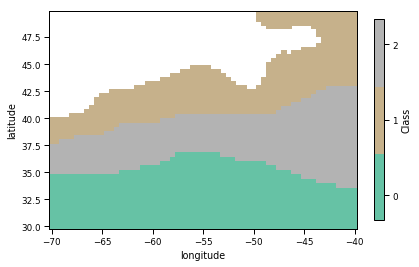

In [9]:
# Easiest way of ploting results:
cmap = m.plot.cmap()
ds['PCM_LABELS'].plot(cmap=cmap, add_colorbar=False)
cl = m.plot.colorbar()

In [ ]:
# Nicer map:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=90, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap()
ds['PCM_LABELS'].plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=m.K, add_colorbar=False)
cl = m.plot.colorbar(ax=ax)

gl = pcmplot.latlongrid(ax, fontsize=8, dx=5)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS')
plt.show()

### Probabilities of classes for each data point

In [ ]:
# Easiest way of ploting results:
fig, ax = m.plot.subplots(figsize=(20,5))
for k in m:
    ds['PCM_POST'].sel(pcm_class=k).plot(ax=ax[k])
    ax[k].set_title("Class %i" % k)

In [ ]:
# Nicer maps:
cmap = sns.light_palette("green", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(20,5),subplot_kw=subplot_kw)
for k in m:
    sc = ds['PCM_POST'].sel(pcm_class=k).plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax[k])
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = pcmplot.latlongrid(ax[k], fontsize=8, dx=5, dy=5)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)

### Robustness

In [ ]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = pcmplot.cmap_robustess()
boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ds['PCM_ROBUSTNESS'].plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax)
cl = plt.colorbar(sc, ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

gl = pcmplot.latlongrid(ax)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Robustness')
plt.show()

## Profiles

### Quantiles

Used to plot the typical class profiles

In [ ]:
fig, ax = pcmplot.quant(m, ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

# Figure of PCM properties

In [ ]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Standard PCM:
m = pcm(K=4, features=features_pcm, maxvar=3) # We use a strong reduction (2-dim) to limit the dimensions and size of the plot
m.fit_predict(ds, features=features_in_ds, dim='depth');

## Scaler properties

In [ ]:
m.plot.scaler();
# Equivalent to:
# pcmplot.scaler(m)

# More options:
# m.plot.scaler(style='darkgrid')
# m.plot.scaler(style='darkgrid', subplot_kw={'ylim':[-1000,0]})

## Reducer properties

Plot eigen vectors for a PCA reducer or nothing if no reduced used

In [ ]:
m.plot.reducer();
# Equivalent to:
# pcmplot.reducer(m)

# More options:
# m.plot.reducer(pcalist = range(0,4));
# m.plot.reducer(pcalist = range(0,4), style='darkgrid',  plot_kw={'linewidth':1.5}, subplot_kw={'ylim':[-1400,0]}, figsize=(12,10));

## Scatter plot of features, *as seen by the classifier*

In [ ]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Standard PCM:
m = pcm(K=8, features=features_pcm, maxvar=2) # We use a strong reduction (2-dim) to limit the dimensions and size of the plot
m.fit_predict(ds, features=features_in_ds, dim='depth');

In [ ]:
# To get access to pre-processed data for your own plot/analysis:
X, sampling_dims = m.preprocessing(ds, features=features_in_ds, dim='depth')
X

In [ ]:
# Direct Figure:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim='depth')

# A posteriori adjustements:
# g.set(xlim=(-3,3),ylim=(-3,3))
# g.savefig('toto.png')

In [ ]:
# Combine KDE with histrograms (very slow plot, so commented here):
# g = m.plot.preprocessed(ds, features=features_in_ds, kde=True)

# Diagnostics

## Debugging

Use option ``debug`` to print log messages 

In [ ]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=1)

# Fit with log:
m.fit(ds, features=features_in_ds, dim='depth');

## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [ ]:
# Create a PCM and use several methods to time:
m = pcm(K=3, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds, dim='depth');
m.predict(ds, features=features_in_ds, dim='depth');
m.fit_predict(ds, features=features_in_ds, dim='depth');

In [ ]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

### Compare details of steps for each method

In [ ]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method') # Default group/split
df

### Compare preprocessing steps for each method

In [ ]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

In [ ]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

In [ ]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method')
df

## Dask optimisation

To be done...